Copyright (c) 2022. Cognitive Scale Inc. All rights reserved. Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/master/LICENSE.md)

# Data Statistics and Drift Monitoring in Certifai (v1.3.14)

# Introduction

We introduce Certifai's `data_statistics` evaluation type - a tool to monitor changes in new datasets when compared to a reference dataset. Certifai's `data_statistics` evaluation type will allow users to monitor data trends, analyze data characteristics, and detect the presence of both feature drift and prediction label drift.

The evaluation type evaluates a few aspects related to the aggregation of monitored datasets: <br> <br>
 (1) Data Quality -  Counts of missing data (data not present in the monitored data) or counts of unexpected data (data not present in the reference data), <br>
(2) Feature Quality - Quartiles for numeric features or distribution counts for categorical features, <br>
(3) Feature Drift - Univariate hypothesis testing to detect drift in individual features of the monitored data, <br>
(4) Prediction Distribution - Prediction value quartiles for regression tasks or label distribution counts for classification tasks, and <br>
(5) Prediction Drift - Univariate hypothesis testing to detect drift in the prediction label.

# Setup

We utilize the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult). To run this example notebook, you will first need to run`./prep_adult_data_drift.ipynb` to create data that synthetically demonstrates drift.

The monitored datasets act as data uploads over time, where each dataset number corresponds to a chronological ordering. We inject noise-induced drift into the feature and label distributions of each dataset. The end result is a set of datasets where the latter datasets are distributionally different from the first few datasets. For example, the first monitored dataset (set 0) has ~1% drift, the 7th monitored dataset has ~12% drift, and the last monitored dataset has ~25% drift, when compared to the reference dataset.

***

# Prepare Certifai for Data Statistics Evaluation

In [1]:
# General Python Packages
import numpy as np
import pandas as pd
import random
from copy import deepcopy
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
loc = matplotlib.ticker.MultipleLocator(base=1.0)

import sys
sys.path.append("./utils")
from data_stats_report_utils import *

# Certifai Packages
from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiModel, CertifaiDataset, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue,
                                      CertifaiFeatureDataType, CertifaiFeatureSchema, CertifaiDataSchema)
from certifai.scanner.report_reader import ScanReportReader

## Import the data

In [2]:
DATASET_PATH = './data/adult/'

reference_dataset_file = 'adult_reference_dataset.csv'
monitored_dataset_prefix = 'adult_monitored_dataset_'

datafiles = [f for f in listdir(DATASET_PATH) if isfile(join(DATASET_PATH, f))]
datafiles.remove(reference_dataset_file)
monitored_data_filelist = sorted(datafiles)

In [3]:
monitored_data_filelist

['adult_monitored_dataset_00.csv',
 'adult_monitored_dataset_01.csv',
 'adult_monitored_dataset_02.csv',
 'adult_monitored_dataset_03.csv',
 'adult_monitored_dataset_04.csv',
 'adult_monitored_dataset_05.csv',
 'adult_monitored_dataset_06.csv',
 'adult_monitored_dataset_07.csv',
 'adult_monitored_dataset_08.csv',
 'adult_monitored_dataset_09.csv',
 'adult_monitored_dataset_10.csv',
 'adult_monitored_dataset_11.csv',
 'adult_monitored_dataset_12.csv',
 'adult_monitored_dataset_13.csv']

In [4]:
label_column = 'income' 

reference_data = pd.read_csv(join(DATASET_PATH, reference_dataset_file))
reference_data.head()

,age,workclass,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,predicted
0,25,workclass_Private,education_11th,marital-status_Never-married,occupation_Machine-op-inspct,relationship_Own-child,race_Black,gender_Male,0,0,40,native-country_United-States,0,0
1,38,workclass_Private,education_HS-grad,marital-status_Married-civ-spouse,occupation_Farming-fishing,relationship_Husband,race_White,gender_Male,0,0,50,native-country_United-States,0,0
2,28,workclass_Local-gov,education_Assoc-acdm,marital-status_Married-civ-spouse,occupation_Protective-serv,relationship_Husband,race_White,gender_Male,0,0,40,native-country_United-States,1,0
3,58,workclass_Private,education_HS-grad,marital-status_Married-civ-spouse,occupation_Exec-managerial,relationship_Husband,race_White,gender_Male,0,0,24,native-country_Cuba,0,0
4,44,workclass_Private,education_Some-college,marital-status_Married-civ-spouse,occupation_Machine-op-inspct,relationship_Husband,race_Black,gender_Male,7688,0,40,native-country_United-States,1,1


## Create the Certifai scan object

In this section, we create a Certifai scan object containing the information Certifai needs to run a `data_statistics` scan.


In [5]:
# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
       [
           CertifaiOutcomeValue(1, name='>50k', favorable=True),
           CertifaiOutcomeValue(0, name='<=50k')
       ]),
       prediction_description='Determine whether someone has income >50k')

In [6]:
scan = CertifaiScanBuilder.create('adult', prediction_task=task, output_path='./reports')

In [7]:
# Run scan with no model
scan.add_model(CertifaiModel(id='no_model'))
scan.no_model_access = True

In [8]:
# Add reference dataset
ref_dataset = CertifaiDataset('reference', CertifaiDatasetSource.csv(join(DATASET_PATH, reference_dataset_file)))
scan.add_dataset(ref_dataset)
scan.reference_dataset_id = 'reference'

In [9]:
reference_data.head()

,age,workclass,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,predicted
0,25,workclass_Private,education_11th,marital-status_Never-married,occupation_Machine-op-inspct,relationship_Own-child,race_Black,gender_Male,0,0,40,native-country_United-States,0,0
1,38,workclass_Private,education_HS-grad,marital-status_Married-civ-spouse,occupation_Farming-fishing,relationship_Husband,race_White,gender_Male,0,0,50,native-country_United-States,0,0
2,28,workclass_Local-gov,education_Assoc-acdm,marital-status_Married-civ-spouse,occupation_Protective-serv,relationship_Husband,race_White,gender_Male,0,0,40,native-country_United-States,1,0
3,58,workclass_Private,education_HS-grad,marital-status_Married-civ-spouse,occupation_Exec-managerial,relationship_Husband,race_White,gender_Male,0,0,24,native-country_Cuba,0,0
4,44,workclass_Private,education_Some-college,marital-status_Married-civ-spouse,occupation_Machine-op-inspct,relationship_Husband,race_Black,gender_Male,7688,0,40,native-country_United-States,1,1


## Create the feature schema

In [10]:
cat_value_mappings = {}
cat_indices = [1, 2, 3, 4, 5, 6, 7, 11]
for idx, feature_name in enumerate(reference_data.columns):
    if idx in cat_indices:
        cat_value_mappings[feature_name] = np.unique(reference_data[feature_name])

In [11]:
cat_features = []
for feature, value_columns in cat_value_mappings.items():
    data_type = CertifaiFeatureDataType.categorical(values=list(value_columns))
    feature_schema = CertifaiFeatureSchema(name=feature, data_type=data_type)
    cat_features.append(feature_schema)

In [12]:
num_features = []
num_indices = [0, 8, 9, 10]
for idx, feature_name in enumerate(reference_data.columns):
    if idx in num_indices:
        data_type = CertifaiFeatureDataType.int()
        num_features.append(CertifaiFeatureSchema(name=feature_name, data_type=data_type))

In [13]:
# Add dataset schema to definition + specify outcome column
schema = CertifaiDataSchema(features=cat_features + num_features)
scan.dataset_schema = schema
scan.dataset_schema.outcome_feature_name = 'income'
scan.dataset_schema.predicted_outcome_feature_name = 'predicted'

## Monitor a list of features
The user can provide a list of monitored features of which to keep track. If no list is provided but a model is given, a list of top `N` (default 50) monitored features will be calculated based on feature importance learned from the model. 

In [14]:
# Add Evaluation types
scan.add_evaluation_type('data_statistics')

# Verify we can set a list of monitored features
monitored_features = [
        'age',
        'gender',
        'relationship',
        'capital-gain',
        'education',
        'workclass',
        'hours-per-week',
        'occupation'
    ]

for item in monitored_features:
    scan.add_monitored_feature(item)

# Run the Data Statistics Evaluation Scan



We add one monitored dataset and process that data with Certifai's `data_statistics` evaluation type before moving onto the next dataset. This iterative process mimics a typical data monitoring scenario.

<strong>Note</strong>: Because we insert unexpected category values into the dataset (or categories may appear in latter datasets that are not in the reference dataset), Certifai will produce a list of `WARNING` messages for out of schema values based on the reference dataset. The values that trigger these `WARNINGS` can be viewed in the `Data Quality` and `Feature Quality` sections below.

In [15]:
scan_id_order = {}
for idx, monitored_file in enumerate(monitored_data_filelist):    
    eval_dataset = CertifaiDataset('evaluation', CertifaiDatasetSource.csv(join(DATASET_PATH,monitored_file)))
    scan.add_dataset(eval_dataset)
    scan.evaluation_dataset_id = 'evaluation'

    results = scan.run(write_reports=True)
    scan_id = results['data_statistics']['no_model']['scan']['scan_id']
    scan_id_order[scan_id] = idx
    
    scan.remove_dataset('evaluation')

2022-01-13 12:34:53,882 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group', 'workclass_Never-worked']
2022-01-13 12:34:53,883 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:53,884 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:53,885 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:53,886 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-

Starting scan with model_use_case_id: 'adult' and scan_id: '5d82da174c57'
[--------------------] 2022-01-13 12:34:54.011859 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:54,295 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group', 'workclass_Never-worked']
2022-01-13 12:34:54,297 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:54,298 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:54,300 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:54,301 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-

[####################] 2022-01-13 12:34:54.256228 - 1 of 1 reports (100.0% complete) - Completed all evaluations
[--------------------] 2022-01-13 12:34:54.420561 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: '77f1f8876e5d'
[--------------------] 2022-01-13 12:34:54.420774 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:54,676 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group', 'workclass_Never-worked']
2022-01-13 12:34:54,677 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:54,678 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:54,680 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:54,681 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-

[####################] 2022-01-13 12:34:54.643643 - 1 of 1 reports (100.0% complete) - Completed all evaluations
[--------------------] 2022-01-13 12:34:54.795297 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: 'e4c8b9656592'
[--------------------] 2022-01-13 12:34:54.795385 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:55,054 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group']
2022-01-13 12:34:55,055 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:55,056 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:55,058 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:55,059 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-13 12:34:55,061 root   WAR

[####################] 2022-01-13 12:34:55.021580 - 1 of 1 reports (100.0% complete) - Completed all evaluations
[--------------------] 2022-01-13 12:34:55.190873 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: '330aafff2d7d'
[--------------------] 2022-01-13 12:34:55.191135 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:55,510 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group']
2022-01-13 12:34:55,511 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:55,513 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:55,514 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:55,516 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-13 12:34:55,518 root   WAR

[####################] 2022-01-13 12:34:55.465764 - 1 of 1 reports (100.0% complete) - Completed all evaluations


2022-01-13 12:34:55,705 root   WARNING  Dataset contains value 'workclass_unexpected_group' for feature 'workclass' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:55,706 root   WARNING  Dataset contains value 'education_unexpected_group' for feature 'education' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:55,707 root   WARNING  Dataset contains value 'marital-status_unexpected_group' for feature 'marital-status' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:55,708 root   WARNING  Dataset contains value 'relationship_unexpected_group' for feature 'relationship' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:55,709 root   WARNING  Dataset contains value 'race

[--------------------] 2022-01-13 12:34:55.688104 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: '0fe7c6e9013c'
[--------------------] 2022-01-13 12:34:55.688262 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:56,010 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group', 'workclass_Never-worked']
2022-01-13 12:34:56,011 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:56,012 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:56,014 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:56,016 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-

[####################] 2022-01-13 12:34:55.972963 - 1 of 1 reports (100.0% complete) - Completed all evaluations
[--------------------] 2022-01-13 12:34:56.145471 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: '51aa789156b7'
[--------------------] 2022-01-13 12:34:56.145557 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:56,398 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group']
2022-01-13 12:34:56,398 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:56,399 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:56,401 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:56,402 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-13 12:34:56,404 root   WAR

[####################] 2022-01-13 12:34:56.363898 - 1 of 1 reports (100.0% complete) - Completed all evaluations
[--------------------] 2022-01-13 12:34:56.511323 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: 'e0ae8282afc1'
[--------------------] 2022-01-13 12:34:56.511411 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:56,761 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group', 'workclass_Never-worked']
2022-01-13 12:34:56,762 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:56,763 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:56,765 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:56,766 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-

[####################] 2022-01-13 12:34:56.726356 - 1 of 1 reports (100.0% complete) - Completed all evaluations
[--------------------] 2022-01-13 12:34:56.881367 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: 'ab880a3deb65'
[--------------------] 2022-01-13 12:34:56.881482 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:57,208 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group', 'workclass_Never-worked']
2022-01-13 12:34:57,209 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:57,210 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:57,213 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:57,215 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-

[####################] 2022-01-13 12:34:57.162587 - 1 of 1 reports (100.0% complete) - Completed all evaluations


2022-01-13 12:34:57,403 root   WARNING  Dataset contains value 'workclass_Never-worked' for feature 'workclass' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:57,404 root   WARNING  Dataset contains value 'workclass_unexpected_group' for feature 'workclass' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:57,405 root   WARNING  Dataset contains value 'education_unexpected_group' for feature 'education' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:57,406 root   WARNING  Dataset contains value 'marital-status_unexpected_group' for feature 'marital-status' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:57,407 root   WARNING  Dataset contains value 'relationship_u

[--------------------] 2022-01-13 12:34:57.385556 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: 'f0c3ff3f86f0'
[--------------------] 2022-01-13 12:34:57.385759 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:57,689 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group']
2022-01-13 12:34:57,690 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:57,691 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:57,693 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:57,695 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-13 12:34:57,696 root   WAR

[####################] 2022-01-13 12:34:57.655224 - 1 of 1 reports (100.0% complete) - Completed all evaluations
[--------------------] 2022-01-13 12:34:57.841164 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: '265036e93bb1'
[--------------------] 2022-01-13 12:34:57.841285 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:57,863 root   WARNING  Dataset contains value 'race_unexpected_group' for feature 'race' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:57,865 root   WARNING  Dataset contains value 'gender_unexpected_group' for feature 'gender' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:57,866 root   WARNING  Dataset contains value 'native-country_Holand-Netherlands' for feature 'native-country' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:57,867 root   WARNING  Dataset contains value 'native-country_unexpected_group' for feature 'native-country' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:58,178 root   WARNING  'workclass' contains the following val

[####################] 2022-01-13 12:34:58.129691 - 1 of 1 reports (100.0% complete) - Completed all evaluations


2022-01-13 12:34:58,364 root   WARNING  Dataset contains value 'workclass_Never-worked' for feature 'workclass' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:58,365 root   WARNING  Dataset contains value 'workclass_unexpected_group' for feature 'workclass' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:58,366 root   WARNING  Dataset contains value 'education_unexpected_group' for feature 'education' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:58,368 root   WARNING  Dataset contains value 'marital-status_unexpected_group' for feature 'marital-status' which is not in the schema-defined set of expected values (processing with schema widened to include this value)
2022-01-13 12:34:58,370 root   WARNING  Dataset contains value 'relationship_u

[--------------------] 2022-01-13 12:34:58.350401 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: 'f431ee28d069'
[--------------------] 2022-01-13 12:34:58.350510 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:58,631 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group', 'workclass_Never-worked']
2022-01-13 12:34:58,632 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:58,633 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:58,635 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:58,637 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-

[####################] 2022-01-13 12:34:58.597498 - 1 of 1 reports (100.0% complete) - Completed all evaluations
[--------------------] 2022-01-13 12:34:58.749934 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: '07457a0ce384'
[--------------------] 2022-01-13 12:34:58.750059 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:59,007 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group']
2022-01-13 12:34:59,008 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:59,009 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:59,011 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:59,012 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-13 12:34:59,013 root   WAR

[####################] 2022-01-13 12:34:58.975073 - 1 of 1 reports (100.0% complete) - Completed all evaluations
[--------------------] 2022-01-13 12:34:59.122916 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: 'a45a214ea329'
[--------------------] 2022-01-13 12:34:59.123035 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model


2022-01-13 12:34:59,377 root   WARNING  'workclass' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['workclass_unexpected_group']
2022-01-13 12:34:59,378 root   WARNING  'education' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['education_unexpected_group']
2022-01-13 12:34:59,379 root   WARNING  'marital-status' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['marital-status_unexpected_group']
2022-01-13 12:34:59,381 root   WARNING  'relationship' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['relationship_unexpected_group']
2022-01-13 12:34:59,383 root   WARNING  'race' contains the following values in dataset id 'evaluation' that are not present in the schema-asserted values: ['race_unexpected_group']
2022-01-13 12:34:59,384 root   WAR

[####################] 2022-01-13 12:34:59.343494 - 1 of 1 reports (100.0% complete) - Completed all evaluations
[--------------------] 2022-01-13 12:34:59.495833 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'adult' and scan_id: '18f182b66baa'
[--------------------] 2022-01-13 12:34:59.495921 - 0 of 1 reports (0.0% complete) - Running data_statistics evaluation for model: no_model
[####################] 2022-01-13 12:34:59.721553 - 1 of 1 reports (100.0% complete) - Completed all evaluations


## Aggregate reports from Certifai

In [16]:
reader = ScanReportReader("reports")
reader.list_usecases()
report_scans = reader.list_scans('adult')

data=[[s['date'], ', '.join(s['reportTypes']), s['id']] for s in report_scans]
reports_df = pd.DataFrame(data, columns=['date', 'evals', 'scan id'])

# Sort datasets by upload time
reports_df['dataset_idx'] = reports_df['scan id'].map(scan_id_order)
reports_df.sort_values(by=['dataset_idx'], ascending=True, inplace=True)

In [17]:
reports_df

,date,evals,scan id,dataset_idx
12,20220113T123454,data_statistics,5d82da174c57,0
13,20220113T123454,data_statistics,77f1f8876e5d,1
9,20220113T123455,data_statistics,e4c8b9656592,2
11,20220113T123455,data_statistics,330aafff2d7d,3
10,20220113T123455,data_statistics,0fe7c6e9013c,4
8,20220113T123456,data_statistics,51aa789156b7,5
7,20220113T123456,data_statistics,e0ae8282afc1,6
6,20220113T123457,data_statistics,ab880a3deb65,7
5,20220113T123457,data_statistics,f0c3ff3f86f0,8
3,20220113T123458,data_statistics,265036e93bb1,9


***

# Interpret Certifai Data Statistics Results

# (1) Data Quality of the Monitored Datasets


Data constantly change, and we need to keep track of values as they appear or disappear. With the `data_statistics` evaluation, we can evaluate the data quality of the incoming monitored datasets by tracking the following statistics: <br>

(1) `missing_value`: instances of missing values (i.e. NaNs) in the monitored dataset, either in the entire dataset (`cells`) or by data observation (`rows`), and <br>
(2) `unexpected`: instances where the monitored dataset contain feature values that do not exist in the entire reference dataset (`cells`) or by data observation (`rows`) <br>

In [18]:
data_quality_dict = retrieve_metric(reader, reports_df, 'adult', metric='data_quality')
data_quality_df = generate_data_quality_df(reports_df, data_quality_dict)

columns = ['num_cells_missing_value', 'num_rows_missing_value', \
           'num_cells_unexpected', 'num_rows_unexpected']
data_quality_result = aggregate_counts_features(data_quality_df, columns=columns)

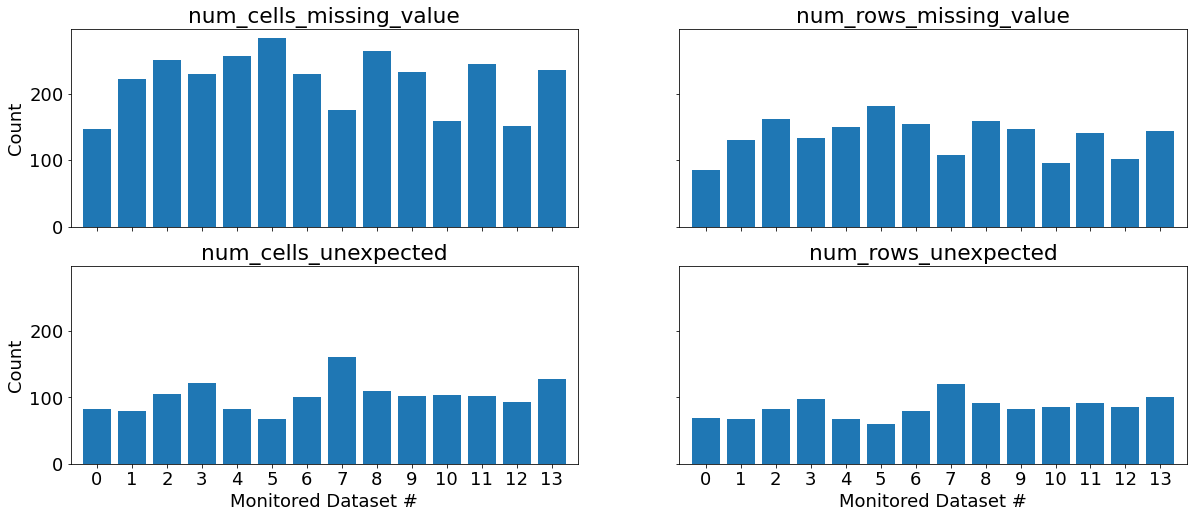

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8), sharey=True)

# Plot the data
for idx, (feature, data_row) in enumerate(data_quality_result.items()):
    col = idx % 2
    row = 0 if idx < 2 else 1
    axs[row, col].bar(range(len(data_row)), data_row)
    axs[row, col].set_title(feature)

# Add labels to the graphs
for ax in axs.flat:
    ax.set(xlabel='Monitored Dataset #', ylabel='Count')
    ax.label_outer()
    ax.xaxis.set_major_locator(loc)
    ax.set_xlim([-0.75, len(data_row)-0.25])

plt.show()

## Analysis:
We observe that the monitored datasets exhibit some cells (rows and columns) where there are missing data (i.e. `NaN`). Recall that in our generated data, we impose that `num_cells_missing_value` > `num_rows_missing_value`, which we can visually verify. We also inserted a categorical value `unexpected_group` in the monitored data that is  not present in the reference set. Certifai is able to detect such anomalies and provide a characterization to highlight these values, which is depicted in `num_cells_unexpected` and `num_rows_unexpected`. 

# (2) Feature Quality in the Monitored Datasets

We can also evaluate the feature quality of the monitored datasets by tracking the following distribution statistics: <br> <br>
(I) Quartiles (min, 25%, 50%, 75%, and max) for numeric features, and <br>
(II) Data counts for categorical features. <br>

The statistics above help monitor the distribution changes in a given feature across uploads of the monitored datasets.

## (2.I) Numeric Feature Analysis

We retrieve the quartiles for the numerical features and visually assess the results.

In [20]:
feature_quality_dict = retrieve_metric(reader, reports_df, 'adult', metric='feature_quality')
feature_quality_num_df, feature_quality_cat_df = generate_feature_quality_df(reports_df, feature_quality_dict)

quality_result_num = aggregate_quartile_features(feature_quality_num_df)

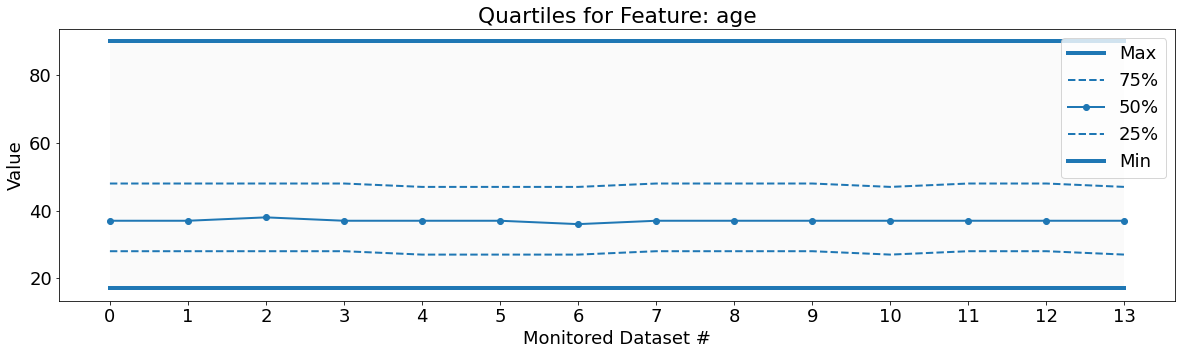

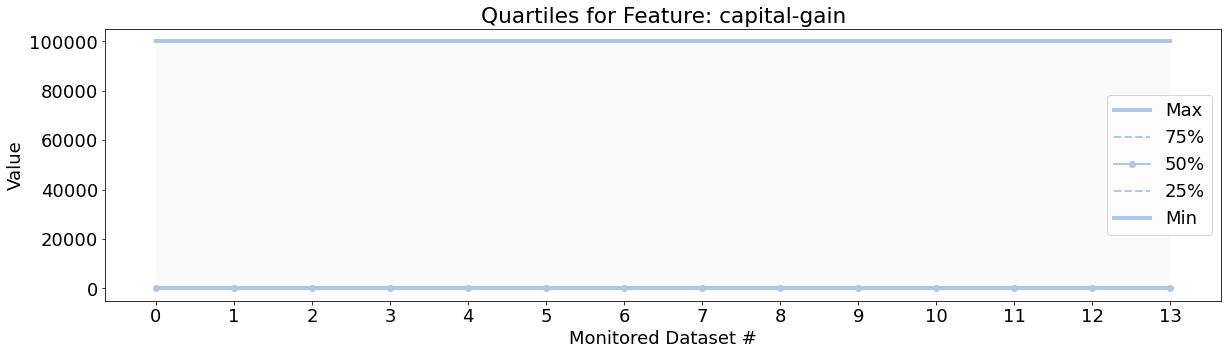

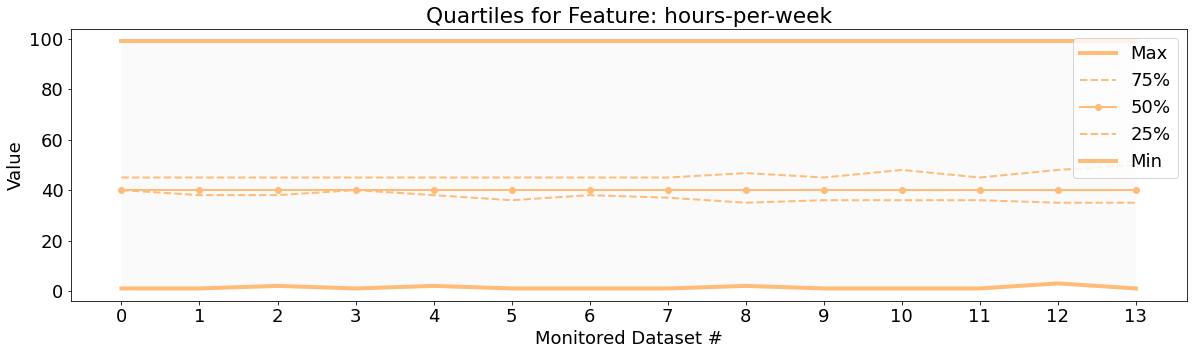

In [21]:
plot_quartile_data(quality_result_num)

## Analysis

We plot the quartiles over all datasets for the monitored numeric features. Recall that in the data generation, we injected drift into the `hours-per-week` feature. Visually we can see that the interquartile range (i.e. 75% to 25%) progressively widens over uploads of the monitored datasets. This is expected since we progressively inserted noise as the monitored dataset ID increases. When comparing the last few datasets (e.g. monitored set 11 and 12) to earlier data uploads (e.g. monitored set 1 and 2), we see that the distribution has widened. We can quantitatively characterize this by looking at the drift statistic (Section 3).

Note: The data for `captial-gain` is highly skewed. 90% of the data has value `0`, and 5% of the data has value `99999`. Thus, the 25-50-75% quartiles are `0`, and the lines overlap.

## (2.II) Categorical Feature Analysis
There are various ways we can investigate the categorical features of the monitored sets. First, we can visualize the count distributions of all the categorical features in <strong>one particular dataset</strong>, Monitored Dataset \#0. This visualization can help the user get a feel for how the categorical data is distributed across the category values. Recall that we injected the `unexpected_group` value, which doesn't exist in the reference set, to test the ability of Certifai to detect unexpected values in the evaluation.

In [22]:
quality_result_cat = aggregate_counts_features(feature_quality_cat_df)

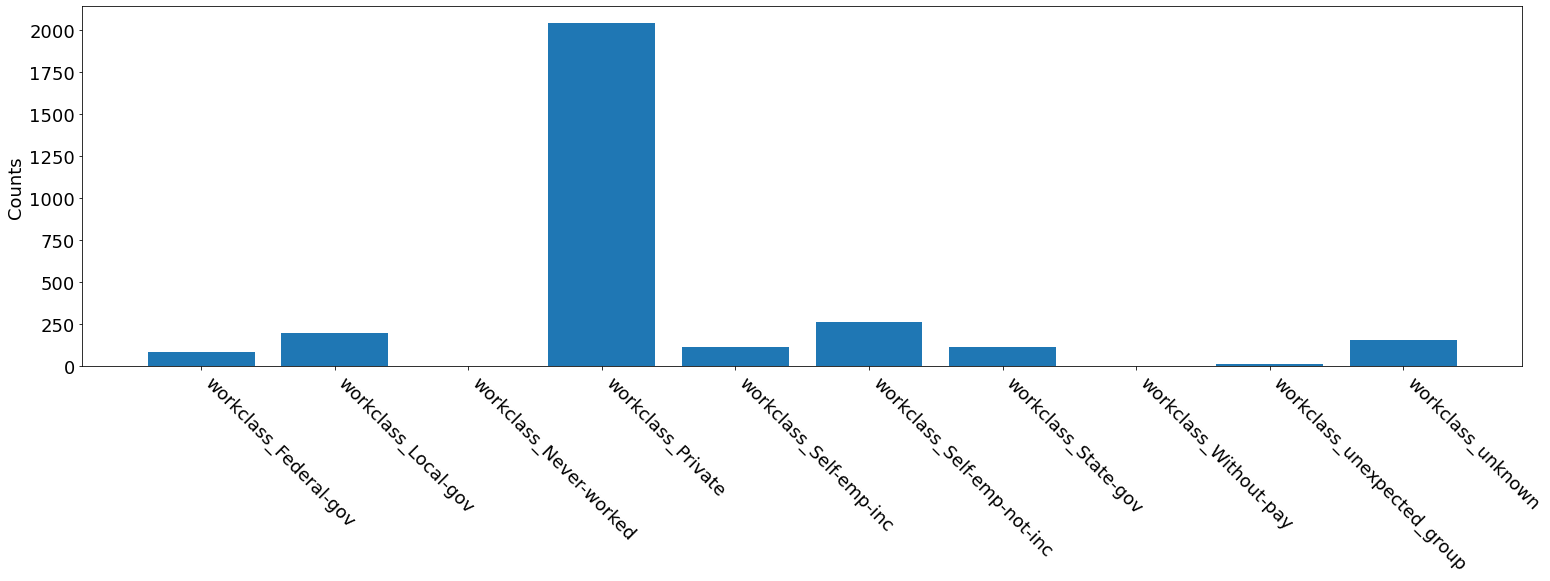

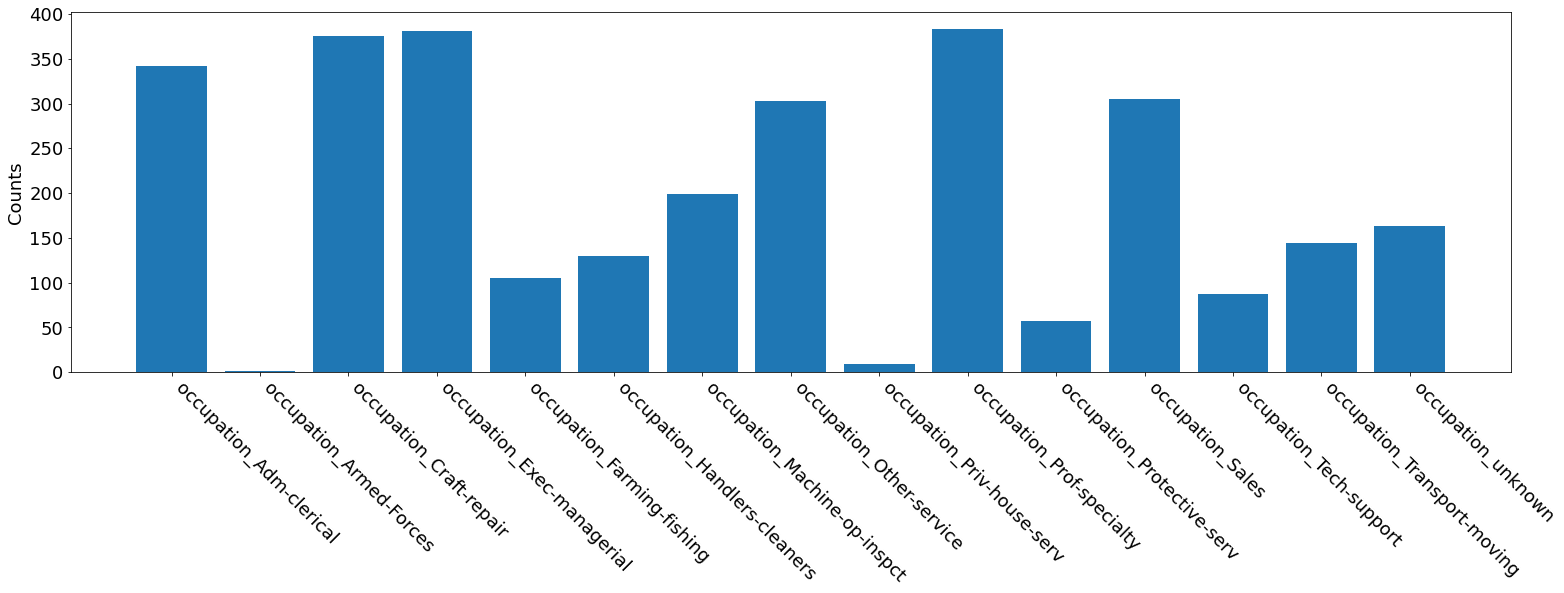

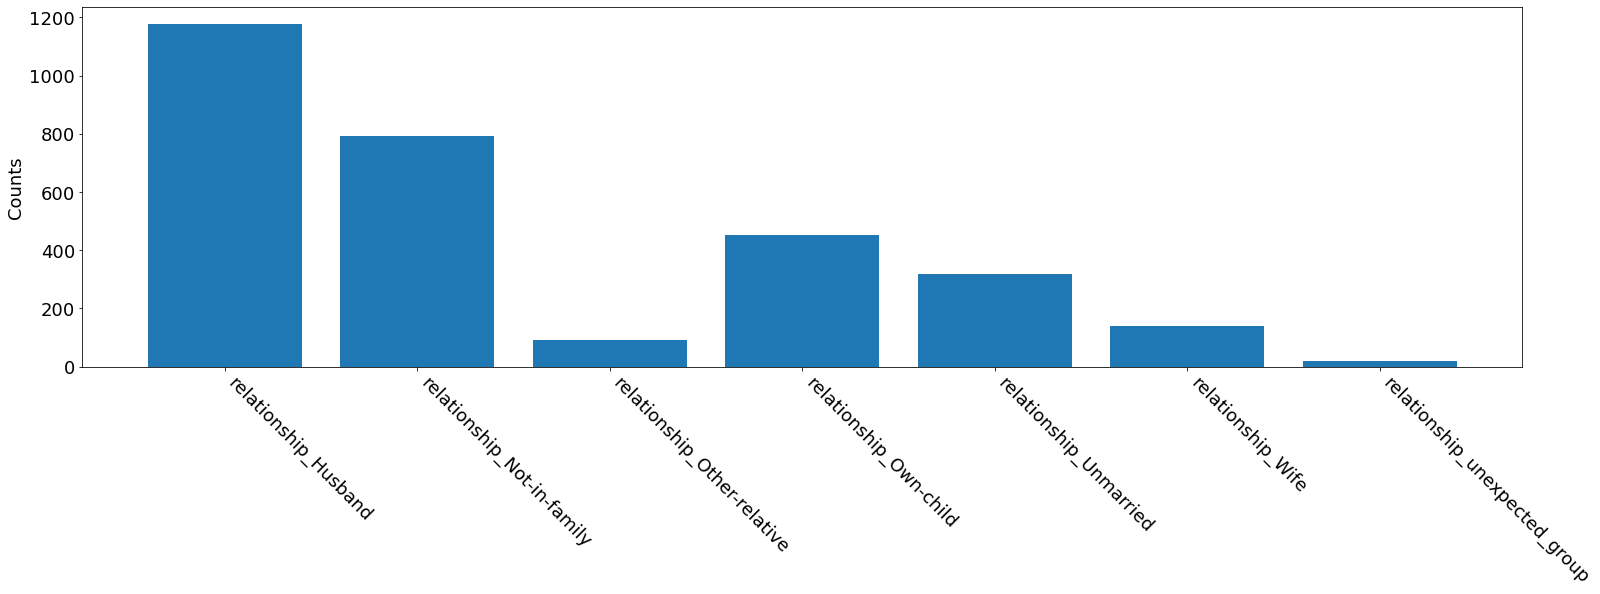

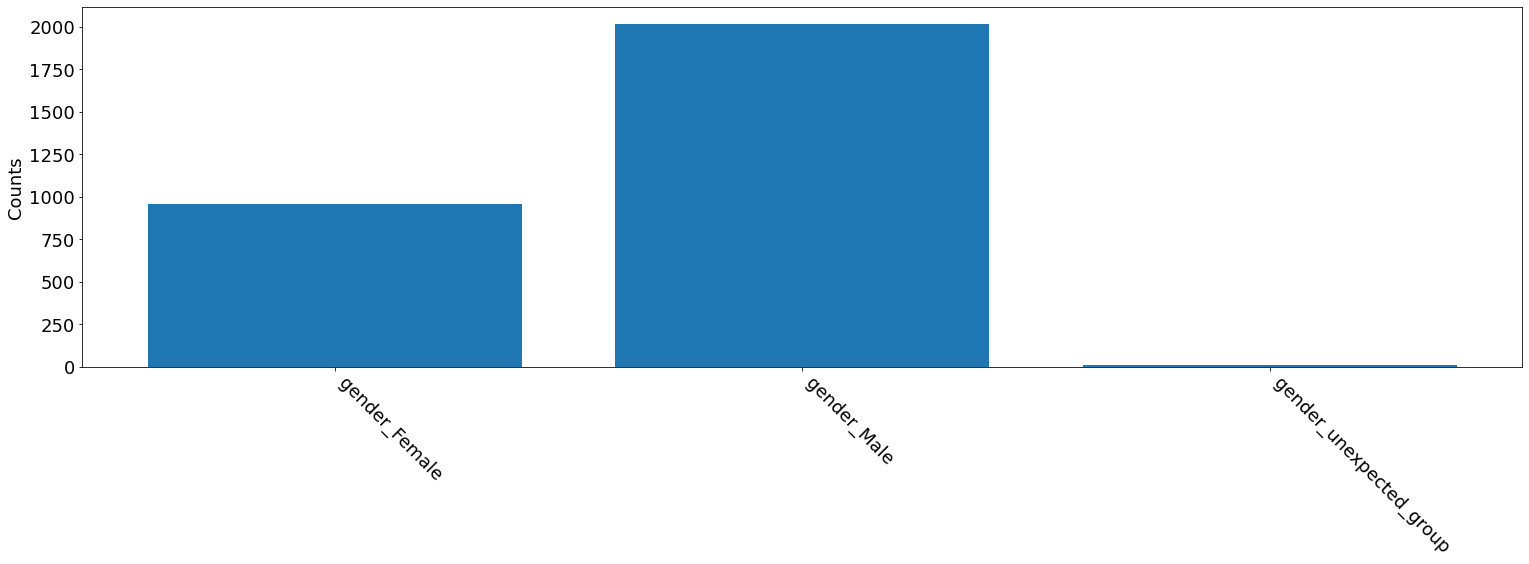

In [23]:
dataset_idx = 0

for idx, (feature, data_row) in enumerate(quality_result_cat.items()):
    fig, ax = plt.subplots(figsize=(20, 5))
    
    X = data_row.keys()
    value = [data_row[key][dataset_idx] for key in X]
    
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X, value)
    label = list(map(lambda x: x.replace('counts_',''), data_row.keys()))
    ax.xaxis.set_ticks(range(len(X)))
    ax.set_xticklabels(label, rotation=-45, ha='left')
    plt.ylabel('Counts')
    plt.show()
    

## (2.II.B) Compare the count distribution of a categorical feature over monitored datasets

The evaluation type will also let us investigate the data distribution over all datasets for any of the features. We take a look at the `workclass` feature below. Recall that drift was injected into the `Federal-gov` category.

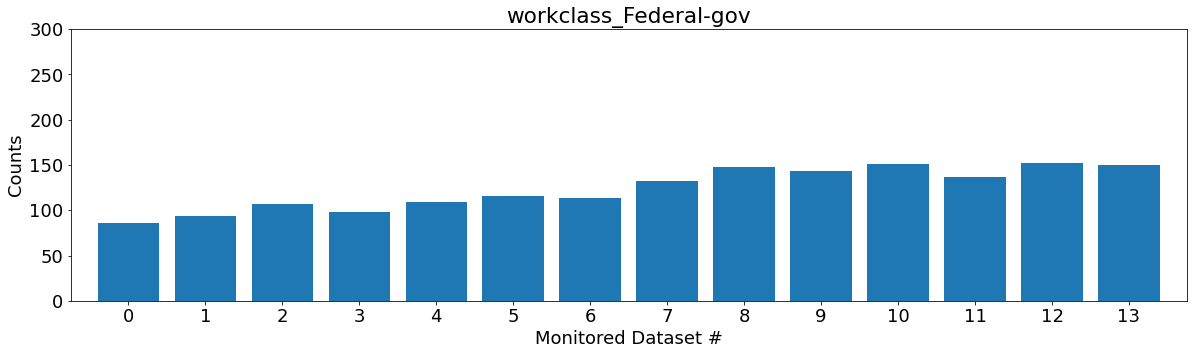

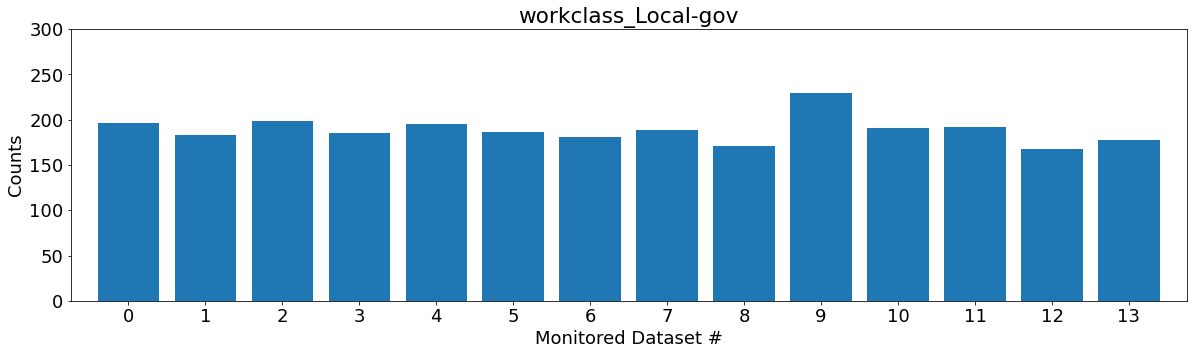

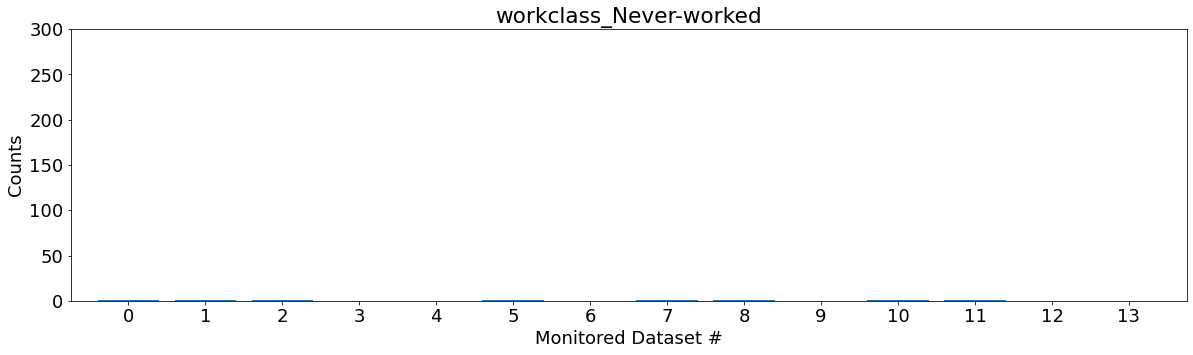

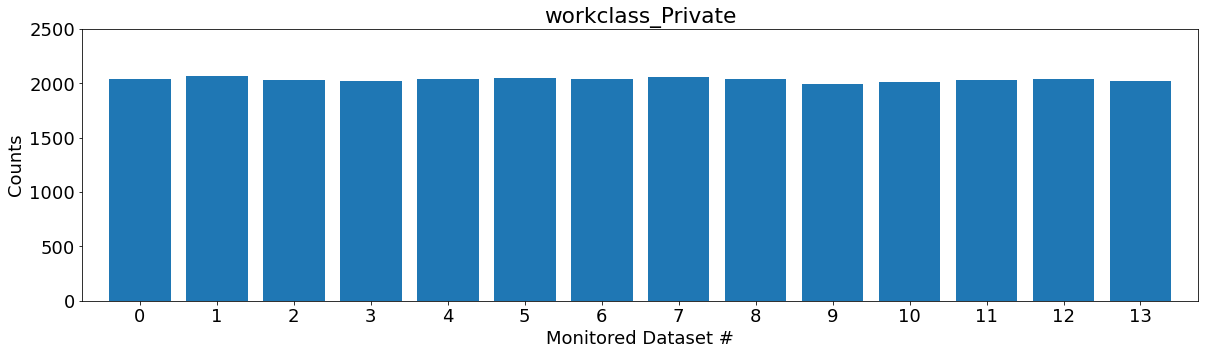

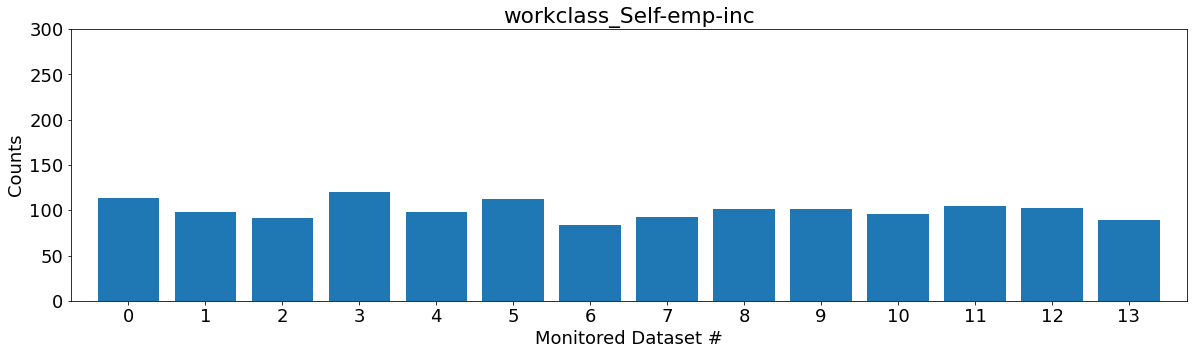

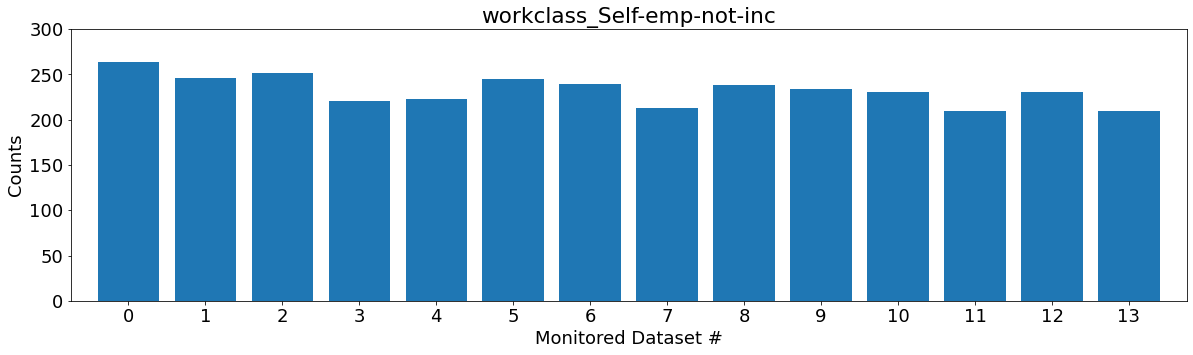

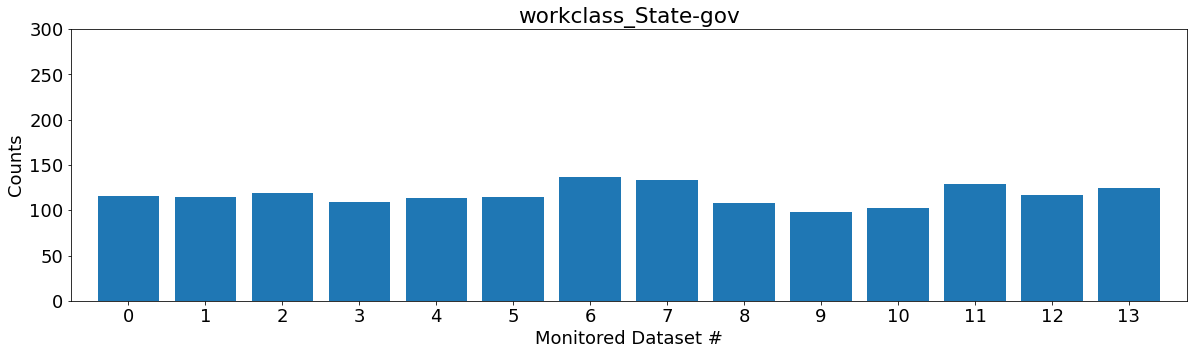

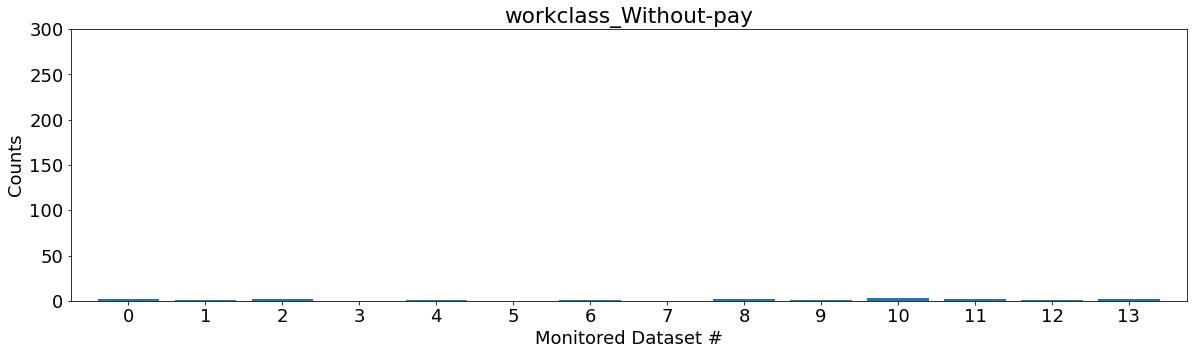

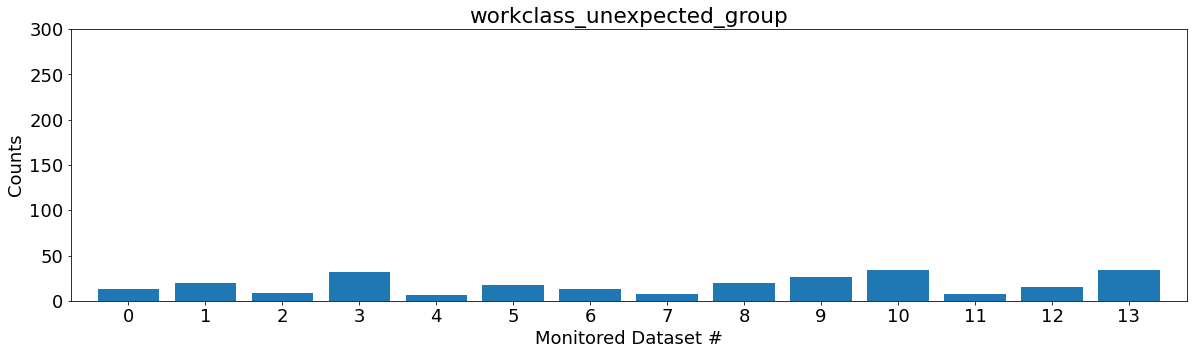

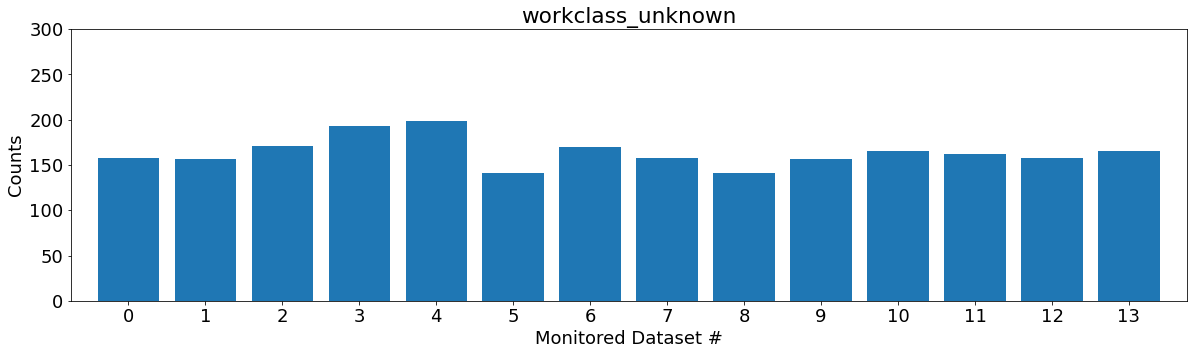

In [24]:
for idx, (feature, data_row) in enumerate(quality_result_cat['workclass'].items()):
    fig, ax = plt.subplots(figsize=(20, 5))
        
    ax.bar(range(0, len(data_row)), data_row)
    
    plt.xlabel('Monitored Dataset #')
    ax.xaxis.set_major_locator(loc)
    ax.set_xlim([-0.75, len(data_row)-0.25])

    plt.title(f"{feature.replace('counts_','')}")
    limits = [0, 2500] if 'Private' in feature else [0, 300]
    ax.set_ylim(limits)
    plt.ylabel('Counts')
    plt.show()

## Analysis
We see that over time (i.e. over monitored datasets), we have an increasing number of instances of the `Federal-gov` categorical value. All the other possible values hold steady or have a decreased number of instances. This is expected since we progressively swap `Federal-gov` for other values to mimic feature drift. Note that the features `Never-worked` and `Without-pay` are sparse features that don't appear in all datasets and that `unexpected_group` is a feature not present in the reference dataset. These values are registered by the `num_cells_unexpected` and `num_rows_unexpected` values in the data quality section of the evaluation.

## (2.II.C) Compare the trend of the percent breakdown per categorical feature over monitored datasets

We can also display the data distribution by percentage for each feature over the monitored datasets. We depict the top 5 values in each categorical feature (determined by highest acount in the reference dataset) and group all the other values together. Note that Certifai only returns count values if a categorical feature has 15 or less values - this helps avoid listing high cardinality features. As a result, categorical features with high cardinality cannot be displayed in this way in the dashboard. 

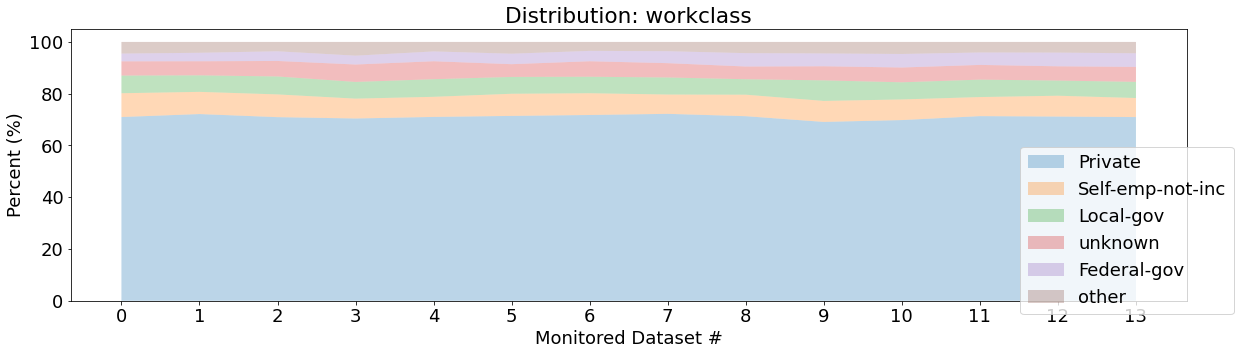

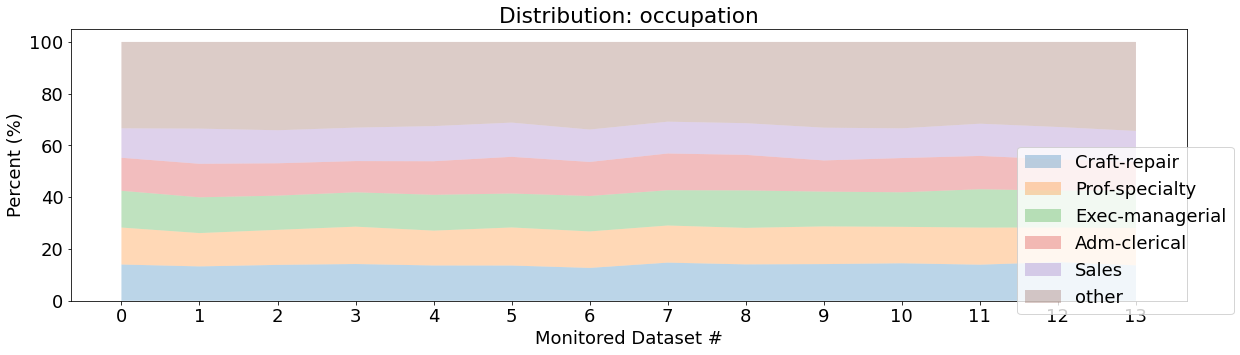

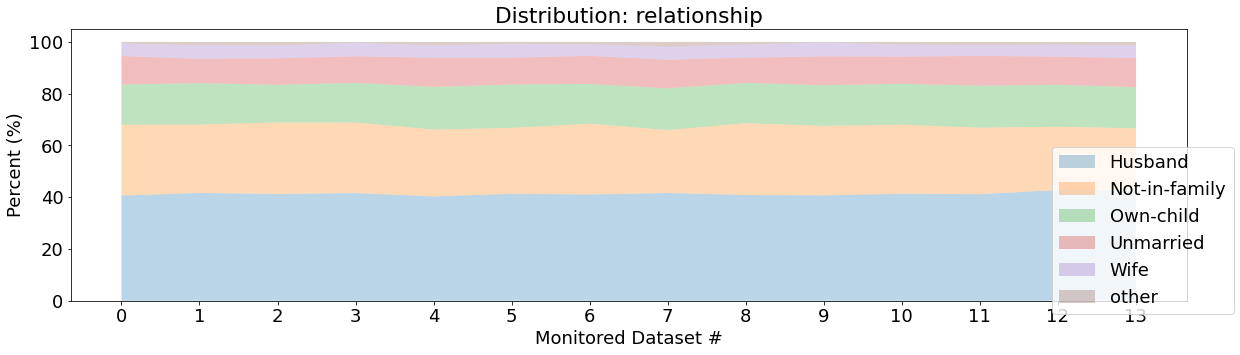

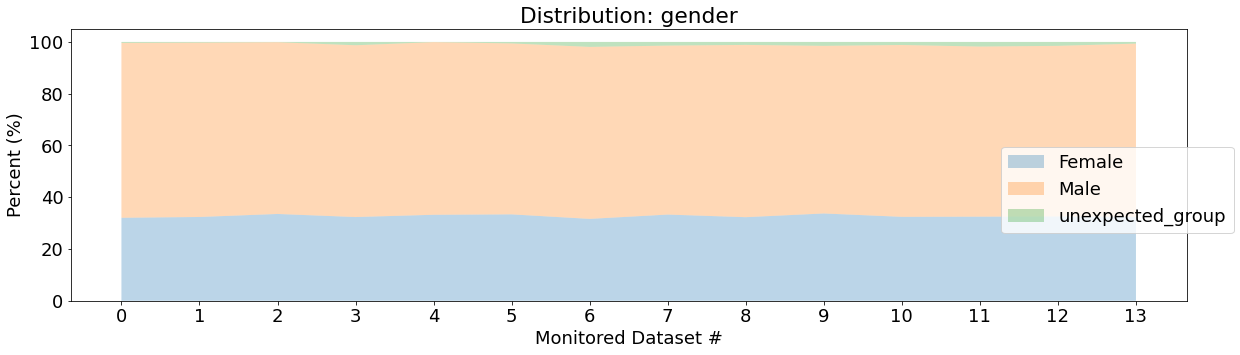

In [25]:
plot_stacked_count(quality_result_cat)

## Analysis

The above feature distribution plots allow a user to quickly visualize trends across their data and gauge whether intervention is needed to retrain models or to investigate recent data uploads. However, sometimes it is difficult to see subtle feature drift. To quantitatively verify if a feature has drifted, Certifai's `data_statistics` evaluation type provides a tool for analysis of data and label drift.

# (3) Feature Drift

We perform data drift detection using univariate hypothesis testing. Depending on the type of the feature (i.e. numeric or categorical) or the type of learning task (i.e. regression or classification), we employ different tests:

### Kolmogorov-Smirnov Statistic for Numeric Drift Detection
The Kolmogorov-Smirnov statistic is a nonparametric evaluation of the similarity of two distributions through the cumulative empirical density function. The null and alternative hypothesis scenario is:

${H_0}$:  the reference dataset (size n) and monitored dataset (size m) are from the same distribution (i.e. no drift)

${H_a}$:  the datasets are NOT from the same distribution (i.e. data drift)

We reject the ${H_0}$ when $D_{KS} > \sqrt{\log(\frac{2}{\alpha}) \cdot \frac{m+n}{2mn}}$, where $D_{KS}$ is the KS statistic. This threshold is derived from a first order approximation on the asymptotic bounds for confidence level-(1-$\alpha$). To account for multiple hypothesis testing (i.e. Bonferroni correction), we let $\alpha = \frac{0.05}{\# \,tests}$. 


### $\chi^2$ Statistic for Categorical Drift Detection
The $\chi^2$ test is a hypothesis test used primarily for count data. The null and alternative hypothesis scenario is: 

${H_0}$:  the reference and monitored datasets are from the same distribution (i.e. no drift)

${H_a}$:  the datasets are NOT from the same distribution (i.e. data drift)

We reject the ${H_0}$ when the critical value is breached: $\chi^2 > \phi(\chi^2, df)$, where $\phi$ is the $\chi^2$ probability distribution and $df$ is the degrees of freedom (i.e. $(\# \, rows-1) * (\# \, cols-1)$). We let $\alpha = \frac{0.05}{\# \,tests}$ to correct for multiple comparisons. 

## Evaluate the feature drift statistic over time

We are interested in detecting the presence of drift in any of the features of the monitored datasets. Each feature in the monitored datasets is compared to the same feature in the reference dataset. Recall that we artificially induced noise into some of the features to mimic distributional shifts in the data (see the data generation notebook for details). Specifically, for the `workclass` and `education` features, we shift the distribution by swapping any value for `workclass_Federal` and `education_Doctorate`, respectively. For the numeric feature `hours-per-week`, we insert Gaussian noise such that the interquartile range (i.e 75% and 25% range) increases. 

After running Certifai's `data_statistics` evaluation, we can aggregate the drift results from each of the scan reports. We then can track the appropriate drift statistic (KS or CS depending on the data type) for each of the features as a function of the time of the dataset upload. In addition to the drift statistics, we display the threshold value that signifies whether the drift metric is statistically significant. Any crossing of the drift statistic above the threshold value would trigger an alert for data drift. Note that each dataset can have a unique crossing or non-crossing. If a dataset exhibits a statistically significant drift, a user will be alerted and then can focus their attention on how to resolve the drift - for example, retrain the model or investigate the data in question.

In [26]:
feature_drift_dict = retrieve_metric(reader, reports_df, 'adult', metric='feature_drift')
feature_drift_df = generate_data_drift_df(reports_df, feature_drift_dict)
drift_result = aggregate_drift_features(feature_drift_df)

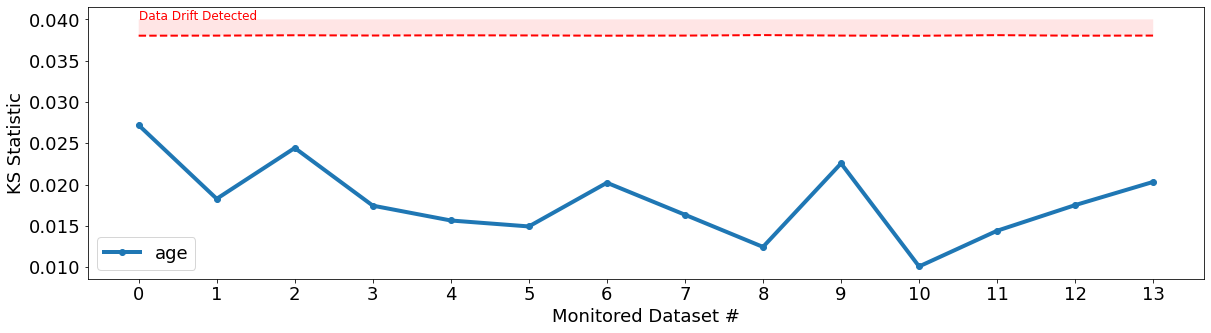

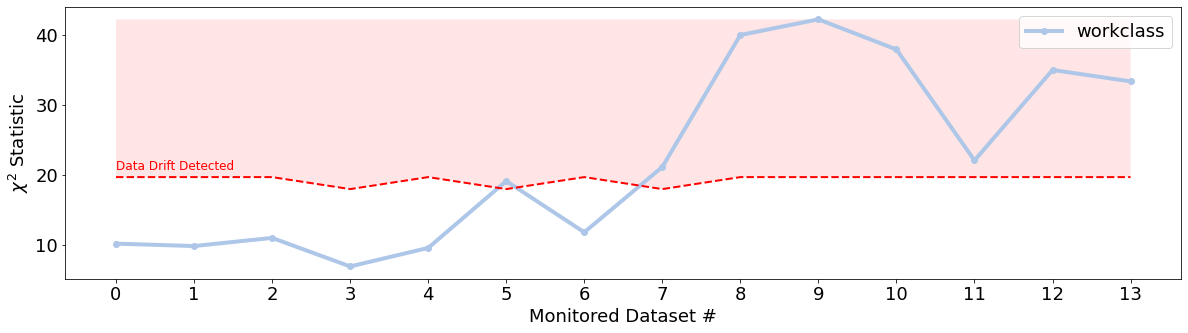

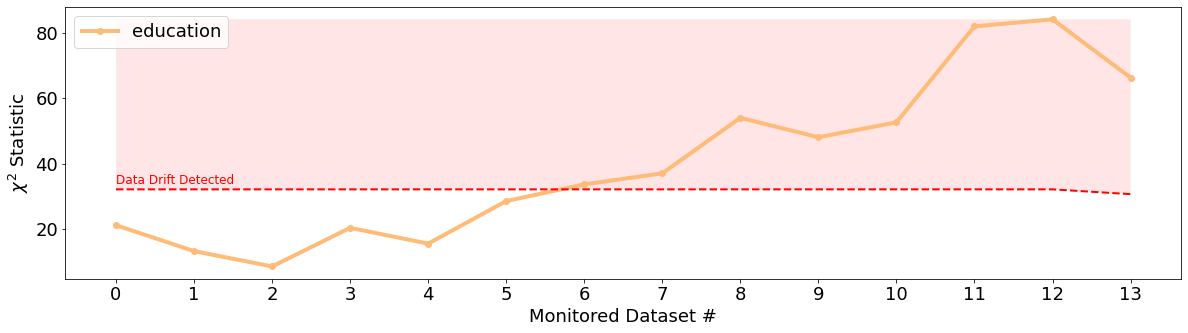

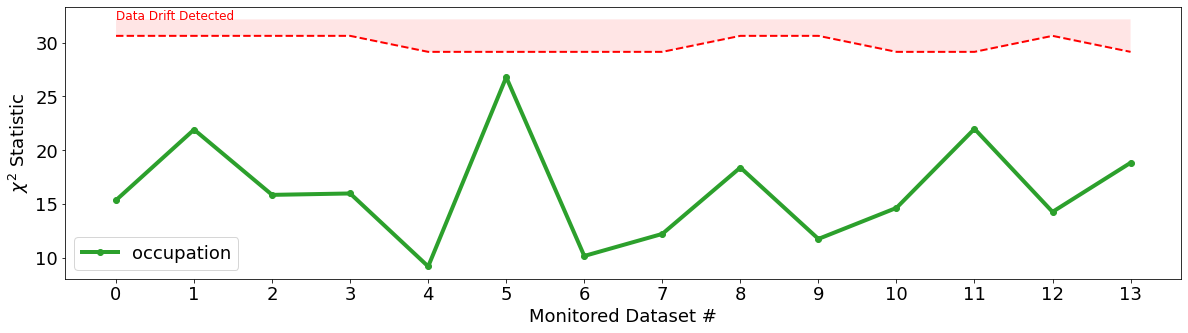

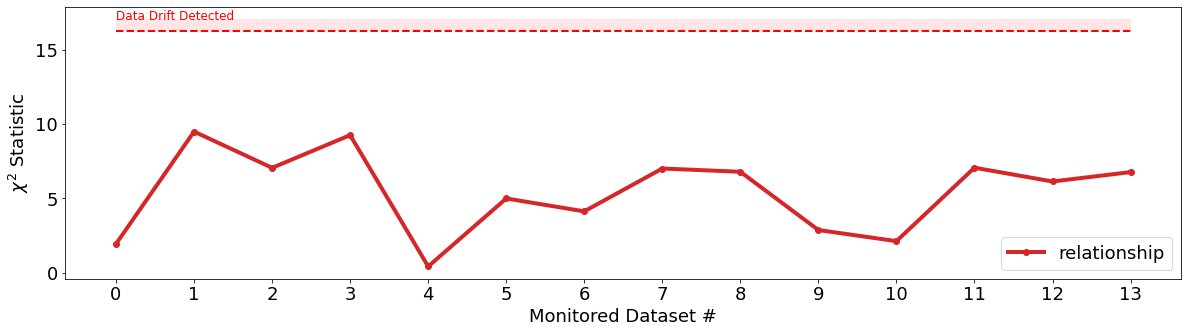

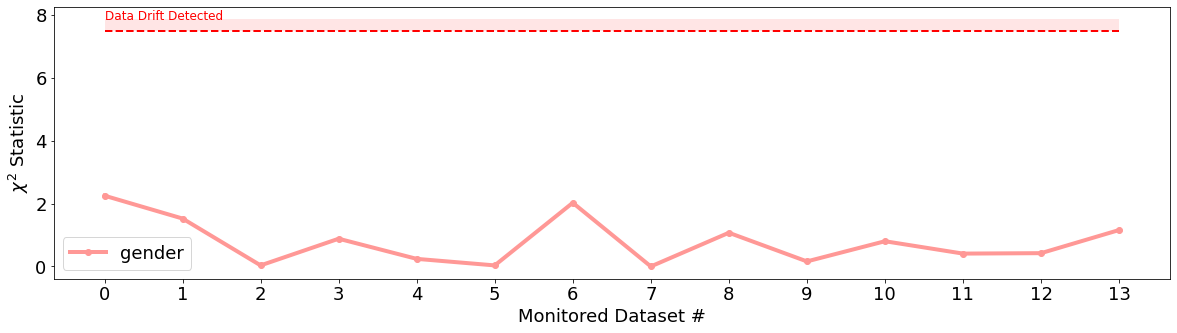

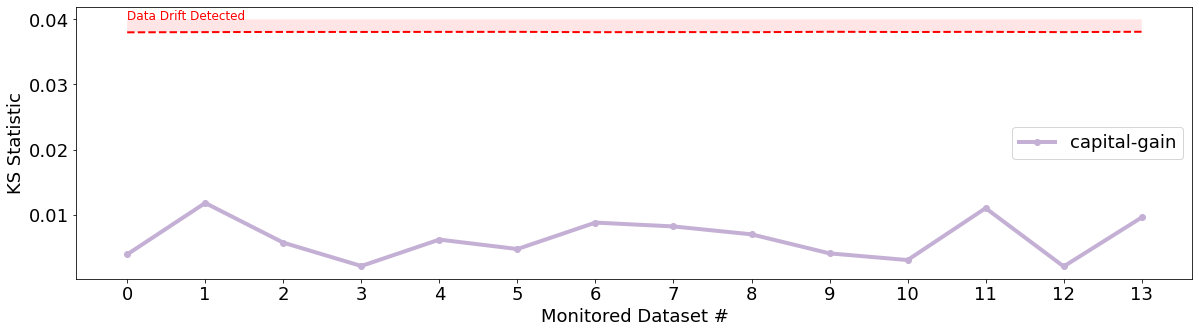

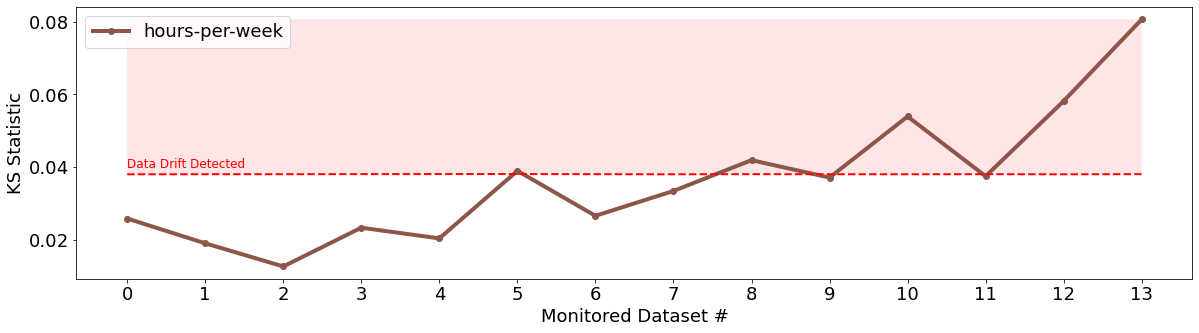

In [27]:
plot_drift(drift_result)

## Analysis
According to the hypothesis test results, the latter monitored datasets exhibit drift in the features: `workclass`, `education`, and `hours-per-week`. This is expected since we progressively induced a distribution shift over the course of the monitored datasets (i.e. time). The other features were kept true to their data distributions, and thus, we can see the natural changes in the distribution of these features - though not enough to trigger a drift warning.

# (4) Prediction distribution in the Monitored Datasets

We can also assess the trend in the distribution of the prediction labels of the monitored datasets and determine if drift from the reference predictions has occurred. Label drift for classification tasks is determined using a chi-squared hypothesis test (i.e. treated as categorical) while drift for regression tasks is determined using a Kolmogorov-Smirnov hypothesis test (i.e. treated as numeric)

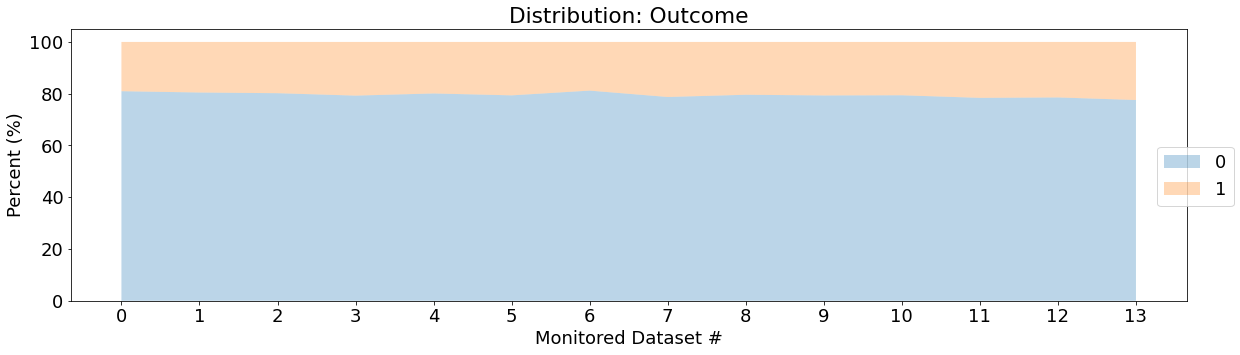

In [28]:
prediction_quality_dict = retrieve_metric(reader, reports_df, 'adult', metric='prediction_distribution')
prediction_distribution_df = unravel_prediction_dict(prediction_quality_dict)
plot_prediction_distribution(prediction_distribution_df)

## Analysis
We vaguely see that over the course of the monitored sets the percentage of label `1` increases. Recall that we increased the distribution count of `1` in the data generation step. Using Certifai, however, we can quantitatively describe this drift and better depict the datasets where the drift is statistically significant.

# (5) Prediction drift

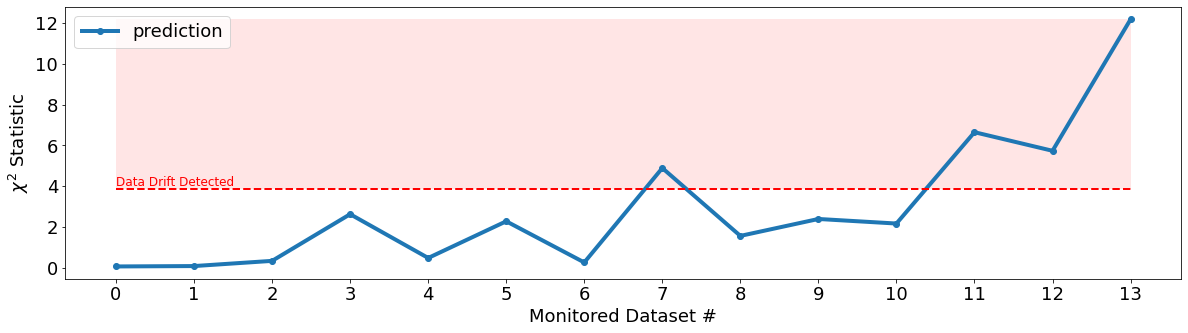

In [29]:
prediction_drift_dict = retrieve_metric(reader, reports_df, 'adult', metric='prediction_drift')
prediction_drift_df = generate_data_drift_df(reports_df, prediction_drift_dict)
plot_drift(prediction_drift_df)

## Analysis
We can see when the drift in the labels becomes statistically significant for a few of the datasets (i.e. crossing the threshold). Note here that even though we are gradually increasing the amount of drift over time, the drift is introduced in a stochastic fashion and independently for each dataset. Therefore, while Monitored Dataset \#7 crosses the threshold, subsequently monitored datasets are not guaranteed to cross the drift threshold.

# Conclusion
Beyond visually examining distributions for changes, the drift tests presented in this notebook give statistical meaning and the quantitative ability to set alerts for when a data distribution changes, both for feature and prediction monitoring